## Árvore de Decisão

In [5]:
""" Imports """
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree # Importante para a Árvore de Decisão e sua visualização
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Início do Notebook: Árvore de Decisão ---")


--- Início do Notebook: Árvore de Decisão ---


In [6]:
# 1. Carregar o dataset
try:
    df_walmart = pd.read_csv('..//data//Walmart.csv')
    print("Dataset 'Walmart.csv' carregado com sucesso!")
    print("\nPrimeiras 5 linhas do dataset:")
    print(df_walmart.head())
    print("\nInformações gerais do dataset antes do pré-processamento:")
    df_walmart.info()
except FileNotFoundError:
    print("Erro: O arquivo 'Walmart.csv' não foi encontrado.")
    print("certifique-se de que o arquivo esteja no mesmo diretório do seu script.")

Dataset 'Walmart.csv' carregado com sucesso!

Primeiras 5 linhas do dataset:
   invoice_id   Branch         City                category unit_price  \
0           1  WALM003  San Antonio       Health and beauty     $74.69   
1           2  WALM048    Harlingen  Electronic accessories     $15.28   
2           3  WALM067  Haltom City      Home and lifestyle     $46.33   
3           4  WALM064      Bedford       Health and beauty     $58.22   
4           5  WALM013       Irving       Sports and travel     $86.31   

   quantity      date      time payment_method  rating  profit_margin  
0       7.0  05/01/19  13:08:00        Ewallet     9.1           0.48  
1       5.0  08/03/19  10:29:00           Cash     9.6           0.48  
2       7.0  03/03/19  13:23:00    Credit card     7.4           0.33  
3       8.0  27/01/19  20:33:00        Ewallet     8.4           0.33  
4       7.0  08/02/19  10:37:00        Ewallet     5.3           0.48  

Informações gerais do dataset antes do pré-pr

In [7]:
# 2. limpar e converter a coluna 'unit_price' para numérico (pre processamento inicial)

df_walmart['unit_price'] = df_walmart['unit_price'].astype(str).str.replace('$', '', regex=False).astype(float)

print("\nColuna 'unit_price' convertida para numérico.")



Coluna 'unit_price' convertida para numérico.


In [8]:
# 3. Criar a variável alvo (y) para Classificação
df_walmart['High_Rating'] = (df_walmart['rating'] >= 7).astype(int)

print("\nNova coluna 'High_Rating' (variável alvo) criada. Contagem de classes:")
print(df_walmart['High_Rating'].value_counts())


Nova coluna 'High_Rating' (variável alvo) criada. Contagem de classes:
High_Rating
0    6492
1    3559
Name: count, dtype: int64


In [9]:
# 4. Definir características (X) e a variável alvo (y)
X = df_walmart.drop(['invoice_id', 'date', 'time', 'rating', 'High_Rating', 'City'], axis=1)
y = df_walmart['High_Rating']

# Identificar colunas numéricas e categóricas para o pré-processamento
numeric_features = ['unit_price', 'quantity', 'profit_margin']
categorical_features = ['category', 'payment_method', 'Branch']

print(f"\nCaracterísticas (X) selecionadas: {numeric_features + categorical_features}")
print(f"Variável alvo (y) selecionada: 'High_Rating'")


Características (X) selecionadas: ['unit_price', 'quantity', 'profit_margin', 'category', 'payment_method', 'Branch']
Variável alvo (y) selecionada: 'High_Rating'


In [10]:
# 5. Tratamento de valores ausentes em X antes do ColumnTransformer
for col in numeric_features:
    if X[col].isnull().any():
        mean_val = X[col].mean()
        X[col].fillna(mean_val, inplace=True)
        print(f"Valores ausentes na coluna numérica '{col}' preenchidos com a média.")

for col in categorical_features:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)
        print(f"Valores ausentes na coluna categórica '{col}' preenchidos com o modo.")


Valores ausentes na coluna numérica 'unit_price' preenchidos com a média.
Valores ausentes na coluna numérica 'quantity' preenchidos com a média.


C:\Users\rafae\AppData\Local\Temp\ipykernel_15440\2959526550.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(mean_val, inplace=True)


In [11]:
# 6.  pré-processador  ColumnTransformer e Pipeline
# Standardscaler para colunas numéricas **lembrar que decision tree nao precisa mas é boa prática
# OneHotEncoder para colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [12]:
# 7. Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nDados divididos: Treino={len(X_train)} amostras, Teste={len(X_test)} amostras.")
print(f"Proporção de 'High_Rating' no treino:\n{y_train.value_counts(normalize=True)}")
print(f"Proporção de 'High_Rating' no teste:\n{y_test.value_counts(normalize=True)}")



Dados divididos: Treino=7035 amostras, Teste=3016 amostras.
Proporção de 'High_Rating' no treino:
High_Rating
0    0.645913
1    0.354087
Name: proportion, dtype: float64
Proporção de 'High_Rating' no teste:
High_Rating
0    0.645889
1    0.354111
Name: proportion, dtype: float64


In [13]:
# 8. Treinar e avaliar o modelo de Árvore de Decisão
# Criar um pipeline que primeiro pré-processa os dados e depois aplica o classificador
# max_depth --> Limita a profundidade da árvore para evitar overfitting
dtree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(max_depth=5, random_state=39))]) #esse numero random_state pode ser qualquer, é só para garantir reprodutibilidade

print("\nTreinando o modelo de Árvore de Decisão...")
dtree_pipeline.fit(X_train, y_train)
print("Treinamento da Árvore de Decisão concluído.")


Treinando o modelo de Árvore de Decisão...
Treinamento da Árvore de Decisão concluído.


In [14]:
# Fazer previsões no conjunto de teste
y_pred_dtree = dtree_pipeline.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred_dtree)
print(f"\n--- Resultados da Árvore de Decisão ---")
print(f"Acurácia da Árvore de Decisão no conjunto de teste: {accuracy:.4f}")

print("\nRelatório de Classificação (Precision, Recall, F1-score):")
print(classification_report(y_test, y_pred_dtree, target_names=['Baixa Avaliação (0)', 'Alta Avaliação (1)']))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred_dtree)
print(cm)


--- Resultados da Árvore de Decisão ---
Acurácia da Árvore de Decisão no conjunto de teste: 0.6532

Relatório de Classificação (Precision, Recall, F1-score):
                     precision    recall  f1-score   support

Baixa Avaliação (0)       0.66      0.94      0.78      1948
 Alta Avaliação (1)       0.54      0.13      0.21      1068

           accuracy                           0.65      3016
          macro avg       0.60      0.54      0.50      3016
       weighted avg       0.62      0.65      0.58      3016


Matriz de Confusão:
[[1827  121]
 [ 925  143]]


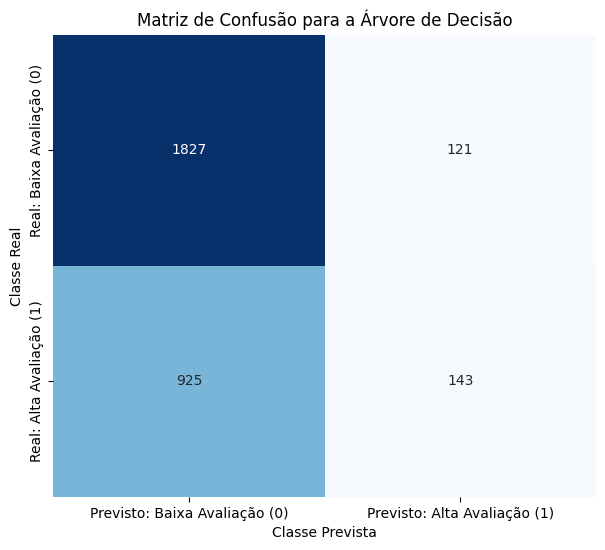

In [15]:
# 9. Visualização da Matriz de Confusão
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=['Previsto: Baixa Avaliação (0)', 'Previsto: Alta Avaliação (1)'],yticklabels=['Real: Baixa Avaliação (0)', 'Real: Alta Avaliação (1)'])
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão para a Árvore de Decisão')
plt.show()

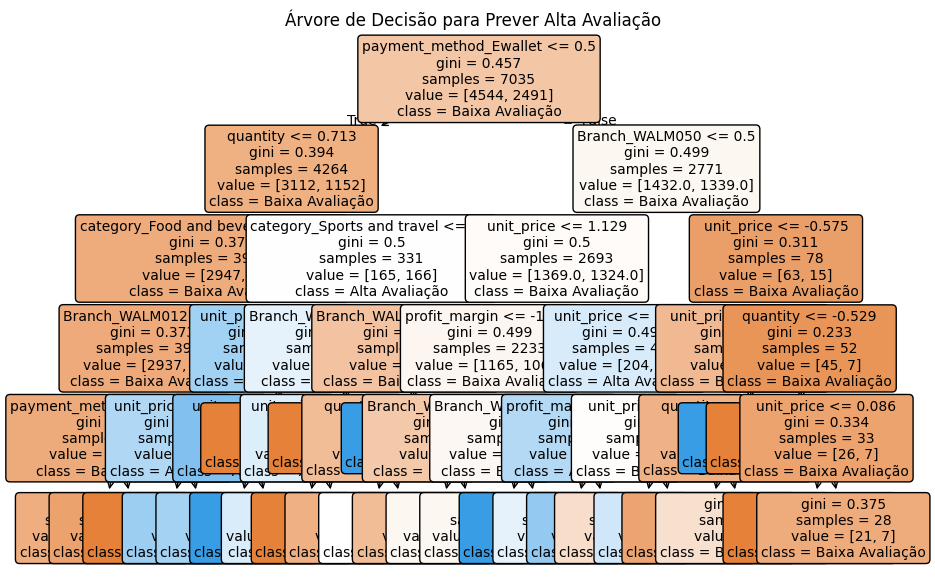

In [16]:
# 10. Visualização da Árvore de Decisão
# tem que acessar o OneHotEncoder do pipeline pra obter os nomes das features transformadas
ohe_feature_names = dtree_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names)

plt.figure(figsize=(10, 7)) 
plot_tree(dtree_pipeline.named_steps['classifier'],feature_names=all_feature_names,class_names=['Baixa Avaliação', 'Alta Avaliação'],filled=True,rounded=True,fontsize=10)
plt.title('Árvore de Decisão para Prever Alta Avaliação')
plt.show()



In [17]:
# Exemplo de uma nova previsão usando o modelo
print("\n--- Exemplo de Nova Previsão com Árvore de Decisão ---")
# Criar um novo ponto de dados com valores hipotéticos
novo_dado_transacao_dt = pd.DataFrame({'unit_price': [77.0],'quantity': [3.0],'profit_margin': [0.39],'category': ['Electronic accessories'],'payment_method': ['Ewallet'],'Branch': ['C']
})

# Fazer a previsão usando o pipeline treinado
previsao_bruta_dt = dtree_pipeline.predict(novo_dado_transacao_dt)
predicted_class_dt = 'Alta Avaliação' if previsao_bruta_dt[0] == 1 else 'Baixa Avaliação'
print(f"O modelo de Árvore de Decisão previu que esta transação terá uma: {predicted_class_dt}")


--- Exemplo de Nova Previsão com Árvore de Decisão ---
O modelo de Árvore de Decisão previu que esta transação terá uma: Alta Avaliação
